# Scattering and absorption of a plasmonic nanoparticle

Plasmonic nanoparticles can exhibit interesting electromagnetic properties at certain frequencies, such as a negative real part of the relative permittivity. Due to their high electrical conductivity, gold nanoparticles can be challenging to model: the rapid field variations inside and near the particles require a fine local discretization. Therefore, an intelligent non-uniform meshing scheme is essential to make sure that the particle is well resolved, while ensuring that the empty space around it does not lead to wasted simulation effort.

Scattering from a 10 nm gold sphere is modeled in this example, and results are compared to the analytical Mie series. This example uses the total-field-scattered-field ([TFSF](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.TFSF.html)) source to excite the particle, and illustrates how to compute various quantities like the total absorbed power, total scattering cross-section, and forward cross-section. A non-uniform mesh is carefully designed to make sure the sphere is well resolved without a significant sacrifice in efficiency. For a more detailed demonstration on TFSF, please refer to the [TFSF tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/TFSF/).

For more simulation examples, please visit our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.

In [1]:
# standard python imports
import matplotlib.pyplot as plt
import numpy as np

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

## Define the structure and boundary conditions
Note the special treatment in creating the mesh: we need to make sure that the mesh is sufficiently fine within the sphere, but we can also make use of `Tidy3D`'s non-uniform meshing algorithm to have a coarser grid outside the sphere, for better efficiency. Furthermore, the TFSF source works best if placed in a region with uniform mesh. Because of this, we will add a mesh override structure which is slightly larger than the sphere itself.

In [2]:
# radius and location of the nanoparticle
radius = 5e-3
center = [0, 0, 0]

# nanoparticle material
medium = td.material_library["Au"]["RakicLorentzDrude1998"]

# free space central wavelength of the pulse excitation
wavelength = 530e-3
f0 = td.C_0 / wavelength

# bandwidth in Hz
fwidth = f0 / 5.0
fmin = f0 - fwidth
fmax = f0 + fwidth
wavelength_max = td.C_0 / fmin
wavelength_min = td.C_0 / fmax

# distance between particle and the boundary of the tfsf box
buffer_tfsf = 0.3 * radius
tfsf_size = (radius + buffer_tfsf) * 2

# distance between the particle and the scattered field region monitors (should be larger than buffer_tfsf)
buffer_out = 0.4 * radius
out_size = (radius + buffer_out) * 2

# distance between the particle and the total field region monitor (should be smaller than buffer_tfsf)
buffer_in = 0.2 * radius
in_size = (radius + buffer_in) * 2

# distance between particle and the mesh override region
buffer_override = 0.8 * radius
override_size = (radius + buffer_override) * 2

# The nanoparticle is very electrically small in the frequency range considered here, and meshing
# based on a standard 10-30 points per wavelength would lead to a grid too coarse to resolve the
# curvature of the sphere. Instead, we just define how many cells we want within the sphere diameter
# by creating a mesh override region
cells_per_wavelength = 50  # for meshing outside of the particle
cells_in_particle = 60  # for the mesh override region
mesh_override = td.MeshOverrideStructure(
    geometry=td.Box(center=center, size=(override_size,) * 3),
    dl=(2 * radius / cells_in_particle,) * 3,
)

# create the sphere
sphere = td.Structure(geometry=td.Sphere(center=center, radius=radius), medium=medium)
geometry = [sphere]

# distance between the surface of the sphere and the start of the PML layers along each cartesian direction
buffer_pml = wavelength_max / 2

# set the full simulation size along x, y, and z
sim_size = [(radius + buffer_pml) * 2] * 3

# define PML layers on all sides
boundary_spec = td.BoundarySpec.all_sides(boundary=td.PML())

## Create Source

For our incident field, we use a TFSF source to inject a plane wave incident from below the sphere polarized in the x direction.

In [3]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth)

# the tfsf source is defined as a box around the particle
source = td.TFSF(
    center=center,
    size=(tfsf_size,) * 3,
    source_time=gaussian,
    injection_axis=2,  # inject along the z axis...
    direction="+",  # ...in the positive direction, i.e. along z+
    name="tfsf",
    pol_angle=0,
)

# Simulation run time
run_time = 10 / fwidth

## Create Monitors

Next, we define a number of monitors to analyze the simulation.

- A 3D FluxMonitor inside the TFSF source can be used to compute the power absorbed in the particle. If no power is absorbed, the recorded flux would be 0, since there are no power sources or sinks inside the monitor box. Any flux recorded in the FluxMonitor is then due to the imbalance between the incoming power and the outgoing one, which has been reduced by the particle absorption.

- A 3D FluxMonitor outside the TFSF region can be used to compute the total cross-section, meaning the total power of scattered radiation in all directions.

- A [FieldProjectionAngleMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjectionAngleMonitor.html) can be used to compute the radiated cross-section at a particular angle.

- A 3D Field monitor inside the TFSF region to record the electric field is required to compute the absorbed power. The parameter `colocate` is set to `False` in order to match with the grid specification of the permittivity monitor.

- A 3D permittivity monitor inside the the TFSF region is required to compute the displacement field $D=\epsilon E$ and the absorbed power. In default settings, `colocate` is set to `False` so that the permittivity at the Yee grid locations, exactly as used in the solver, is stored.

- Finally, we also store the fields in a planar cross-section for visualization purposes.

In [4]:
# set the list of frequencies at which to compute quantities
num_freqs = 100
freqs = np.linspace(f0 - fwidth, f0 + fwidth, 100)

monitor_flux_out = td.FluxMonitor(
    size=[out_size] * 3,
    freqs=freqs,
    name="flux_out",
)
monitor_flux_in = td.FluxMonitor(
    size=[in_size] * 3,
    freqs=freqs,
    name="flux_in",
)

# Create near field to far field projection monitor for forward RCS
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=center,
    size=[out_size] * 3,
    freqs=freqs,
    name="n2f",
    phi=[0],
    theta=[0],
)

# Near field monitor for visualization
monitor_near = td.FieldMonitor(
    center=[0, 0, 0],
    size=[out_size, 0, out_size],
    freqs=[f0],
    name="near",
)

monitor_perm = td.PermittivityMonitor(
    size=(in_size,) * 3,
    center=(0, 0, 0),
    freqs=freqs,
    name="permittivity",
)

# Field monitor for absorbed power density
monitor_E_field = td.FieldMonitor(
    center=[0, 0, 0],
    size=(in_size,) * 3,
    freqs=freqs,
    fields=["Ex", "Ey", "Ez"],
    colocate=False,
    name="dft_fields_monitor",
)

monitors = [
    monitor_flux_out,
    monitor_flux_in,
    monitor_n2f,
    monitor_near,
    monitor_perm,
    monitor_E_field,
]

## Create Simulation

Now we can put everything together and define the simulation.

In [5]:
# since the mesh is extremely fine near the particle and transitions to a coarser mesh farther out,
# we can use the 'max_scale' field to set the largest allowed increase in mesh size from one cell to
# the next, to obtain a gentler gradient; the default is 1.4, and we'll set it to 1.2 here
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=cells_per_wavelength,
    override_structures=[mesh_override],
    max_scale=1.2,
)

sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=geometry,
    sources=[source],
    monitors=monitors,
    run_time=run_time,
    boundary_spec=boundary_spec,
    shutoff=1e-8,
)

## Visualize Geometry and Mesh

Let's take a look at the mesh and geometry and make sure everything is defined properly in the simulation. The nanoparticle is very small compared to the simulation and is not visible in the full plot. For better visibility, we also show a zoomed-in plot, which shows how the nanoparticle is meshed. Note that the mesh inside the nanoparticle is quite fine and may not render correctly in the notebook, possibly giving the false impression of being somewhat coarse.

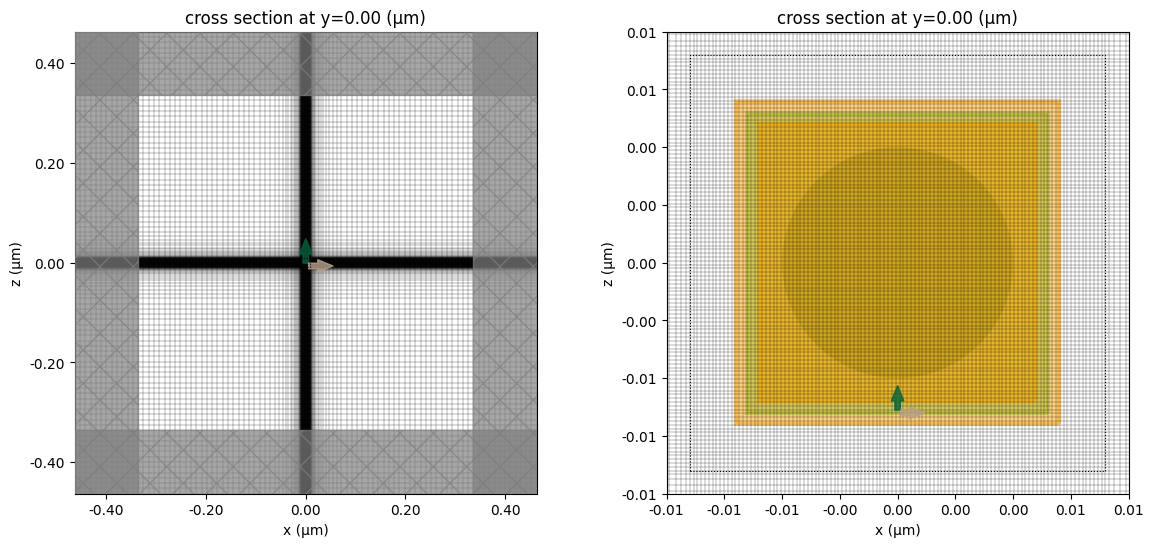

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
zoom = radius * 2
sim.plot(y=0, ax=ax1)
sim.plot_grid(y=0, ax=ax1)
sim.plot(y=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom], monitor_alpha=0.2)
sim.plot_grid(y=0, ax=ax2, hlim=[-zoom, zoom], vlim=[-zoom, zoom])
plt.show()

## Run Simulation


In [7]:
# Run simulation
sim_data = web.run(
    sim,
    task_name="plasmonic_nanoparticle",
    path="data/plasmonic_nanoparticle.hdf5",
    verbose=True,
)

14:40:54 CEST Created task 'plasmonic_nanoparticle' with task_id                
              'fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=370995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=282531;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\taskId]8;;\]8;id=370995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\=]8;;\]8;id=729094;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\fdve]8;;\]8;id=370995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\-a9651766-bb]8;;\
              ]8;id=370995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\e5-430e-8581-4ec6e7885bd6']8;;\.

              Task folder: ]8;id=94153;https://tidy3d.simulation.cloud/folders/9b36e144-ddb6-41f8-8dd8-30b62b26a870\'default']8;;\.

Output()

14:40:58 CEST Maximum FlexCredit cost: 1.250. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

14:40:59 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

14:41:14 CEST starting up solver

              running solver

Output()

14:43:14 CEST early shutoff detected at 44%, exiting.

              status = postprocess

Output()

14:43:59 CEST status = success

14:44:01 CEST View simulation result at                                         
              ]8;id=613541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=769661;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\taskId]8;;\]8;id=613541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\=]8;;\]8;id=919476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\fdve]8;;\]8;id=613541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\-a9651766-bb]8;;\
              ]8;id=613541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9651766-bbe5-430e-8581-4ec6e7885bd6\e5-430e-8581-4ec6e7885bd6']8;;\.

Output()

14:46:52 CEST loading simulation from data/plasmonic_nanoparticle.hdf5

## Extract the results

In [8]:
# Total absorbed power
absorbed = np.abs(sim_data["flux_in"].flux)

# Total scattered power
scattered = sim_data["flux_out"].flux

# Power scattered in the forward direction
RCS = np.squeeze(np.real(sim_data["n2f"].radar_cross_section.values))

### Absorbed Power Distribution

The dissipated power in a lossy material when subjected to a time-harmonic electromagnetic field is a quantity that can be computed from the electric field $E$ and the permittivity $\varepsilon$. For futher thoretical details, refer to [1].

The **volumetric power absorption density**, denoted as $p_{\text{abs}}(x, y, z)$, measures the power absorbed per unit volume at a specific point. Realistic metallic properties are described through a **complex permittivity** $\varepsilon_c = \varepsilon' - j\varepsilon''$. Here, $\varepsilon''$, the imaginary part, accounts for dielectric losses. The volumetric absorption density can be defined as $p_{\text{abs}}(x, y, z) = -\frac{1}{2}\omega\varepsilon''|E|^2$. 

A more general way to express this quantity is by using the dot product of the electric $E$ and displacement fields $D$. For a linear isotropic material, given the relation $D = \varepsilon_c E = (\varepsilon' - j\varepsilon'')E$, it is easily verifiable that $\varepsilon'' |E|^2 = -\text{Imag}\{ E^* \cdot D\}$. Substituting this into our derived formula gives
$$p_{\text{abs}}(x,y,z) = \frac{1}{2}\omega \text{Imag}\{E^*(x, y, z) \cdot D(x, y, z)\}$$
where:
* **$\omega$** is the angular frequency ($2\pi f$) of the field in rad/s.
* **$E^*(x, y, z)$** is the complex conjugate of the electric field.
* **$D(x, y, z)$** is the electric displacement field.
* **$\text{Imag}$** denotes the imaginary part of the argument.

This expression, employing $E^*$ and $D$, is the most general form for losses because it derives directly from Poynting's theorem on energy conservation. It remains universally valid for anisotropic and nonlinear media by using the material's true response $D$, without assuming it must be parallel or proportional to the driving field $E$. To find the **total absorbed power** ($P_{\text{abs}}$) within a specific volume $V$, one must integrate the volumetric power density over that volume:

$$P_\text{abs} = \int_V p_\text{abs} (x, y, z) = \int_V \frac{1}{2} \omega \; \text{Imag} (E^*(x,y,z) \cdot D (x, y, z))\; dV$$

Using the relation $\omega = 2 \pi f$, this can also be written as:

$$P_\text{abs} = \int_V \pi f \; \text{Imag} (E^*(x,y,z) \cdot D (x, y, z)) \; dV$$

[1] Jian-Ming Jin, Theory and computation of electromagnetic fields **sec. 1.7**.


In [9]:
# Extract all components of the E-field.
monitor_data_E = sim_data.monitor_data[monitor_E_field.name]
field_data_colocated = sim_data.at_boundaries(monitor_E_field.name).interp(f=f0, method="nearest")
coords = field_data_colocated.Ex.coords
coords_dict = {dim: coords.get(dim) for dim in "xyz"}

Ex = monitor_data_E.Ex
Ey = monitor_data_E.Ey
Ez = monitor_data_E.Ez

# Extract all components of the permittivity.
monitor_data_perm = sim_data.monitor_data[monitor_perm.name]
perm_x = monitor_data_perm.eps_xx.values
perm_y = monitor_data_perm.eps_yy.values
perm_z = monitor_data_perm.eps_zz.values

The displacement field $D$ can be computed as $D = \epsilon E$. This is possible since `colocate=False` was set on the electric field monitor, allowing the permittivity and electric field data to be defined with the same grid specifications.

In [10]:
# Computing the displacement field
Dx = perm_x * td.constants.EPSILON_0 * Ex
Dy = perm_y * td.constants.EPSILON_0 * Ey
Dz = perm_z * td.constants.EPSILON_0 * Ez

# Compute the power density for each E-field component using the imaginary part of permittivity.
Power_density_E_x = np.pi * freqs * (Ex.conj() * Dx).imag
Power_density_E_y = np.pi * freqs * (Ey.conj() * Dy).imag
Power_density_E_z = np.pi * freqs * (Ez.conj() * Dz).imag

# Integrate each power density component over the spatial coordinates to get absorbed power
absorbed_power_E_x = Power_density_E_x.integrate(coord=["x", "y", "z"])
absorbed_power_E_y = Power_density_E_y.integrate(coord=["x", "y", "z"])
absorbed_power_E_z = Power_density_E_z.integrate(coord=["x", "y", "z"])
# Sum all absorbed power components to get the total absorbed power.
absorbed_power_E = absorbed_power_E_x + absorbed_power_E_y + absorbed_power_E_z

# Power density for a single frequency
Power_density_E_x_f0 = Power_density_E_x.sel(f=f0, method="nearest")
Power_density_E_y_f0 = Power_density_E_y.sel(f=f0, method="nearest")
Power_density_E_z_f0 = Power_density_E_z.sel(f=f0, method="nearest")
Power_density_E_f0 = (
    Power_density_E_x_f0.interp(**coords_dict)
    + Power_density_E_y_f0.interp(**coords_dict)
    + Power_density_E_z_f0.interp(**coords_dict)
)

### Plot the electric field

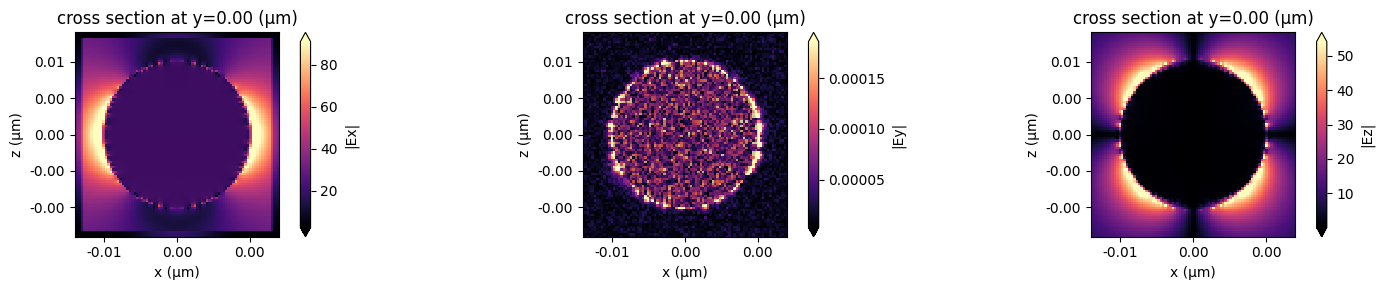

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
fig1 = sim_data.plot_field(field_monitor_name="near", field_name="Ex", val="abs", f=f0, ax=ax[0])
fig2 = sim_data.plot_field(field_monitor_name="near", field_name="Ey", val="abs", f=f0, ax=ax[1])
fig3 = sim_data.plot_field(field_monitor_name="near", field_name="Ez", val="abs", f=f0, ax=ax[2])
plt.tight_layout()

### Plot the absorbed power density

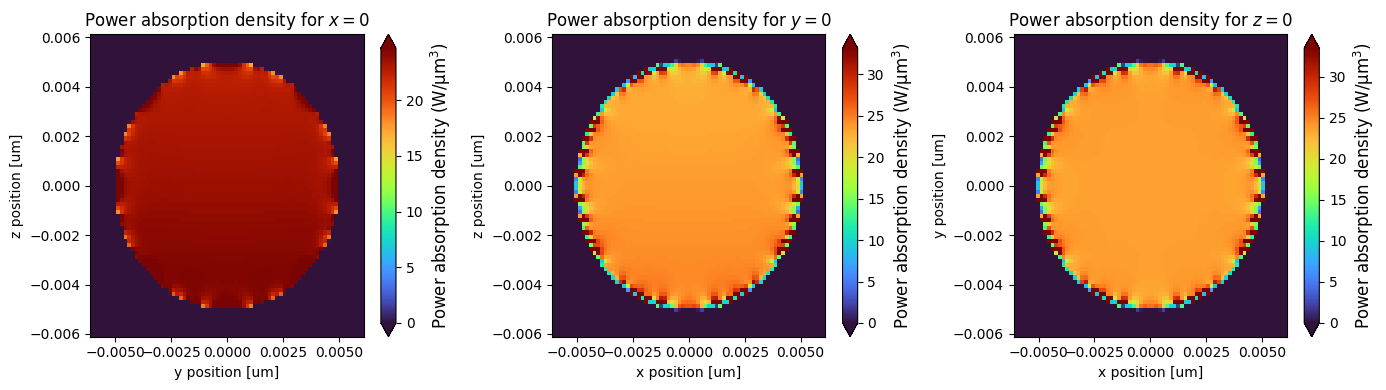

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
fig1 = (
    (Power_density_E_f0)
    .sel(x=0, method="nearest")
    .real.plot(x="y", y="z", cmap="turbo", ax=ax[0], robust=True, vmin=0)
)
fig2 = (
    (Power_density_E_f0)
    .sel(y=0, method="nearest")
    .real.plot(x="x", y="z", cmap="turbo", ax=ax[1], robust=True, vmin=0)
)
fig3 = (
    (Power_density_E_f0)
    .sel(z=0, method="nearest")
    .real.plot(x="x", y="y", cmap="turbo", ax=ax[2], robust=True, vmin=0)
)

colorbar_label = "Power absorption density (W/µm$^3$)"
fig1.colorbar.set_label(colorbar_label, fontsize=12)
fig2.colorbar.set_label(colorbar_label, fontsize=12)
fig3.colorbar.set_label(colorbar_label, fontsize=12)

_ = ax[0].set_title("Power absorption density for $x=0$")
_ = ax[1].set_title("Power absorption density for $y=0$")
_ = ax[2].set_title("Power absorption density for $z=0$")

plt.tight_layout()

## Comparison with Mie Series

The final results are compared against the analytical Mie series below, and very good agreement is observed. The small deviations can be reduced with a further refinement of the grid. Since the sphere's material is metallic, no subpixel averaging scheme is applied, so the simulation approximates the curved permittivity profile in a staircase-like manner, which contributes to the error. The label *Tidy3D: I - S*, standing for incoming minus scattered power, denotes the amount of  power that is absorbed in the source region measured by calculating the flux flowing inward inside the TFSF region.

The txt files containing the Mie results can be downloaded from our documentation [repo](https://github.com/flexcompute/tidy3d-notebooks/tree/develop/misc).

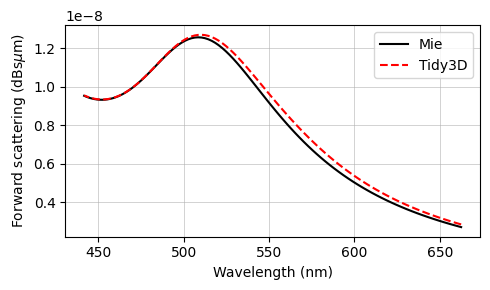

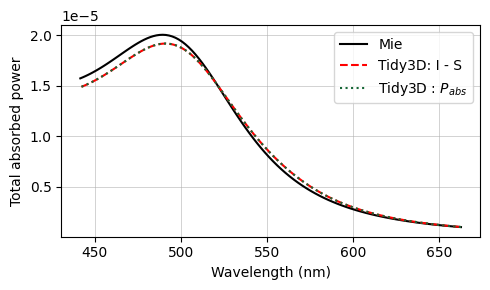

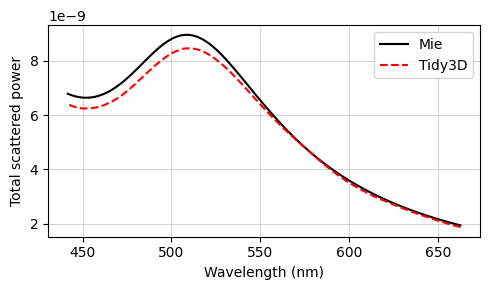

In [13]:
# load Mie series data
savefile_flux_abs = "./misc/mie_plasmonic_flux_abs.txt"
savefile_flux_scat = "./misc/mie_plasmonic_flux_scat.txt"
savefile_RCS = "./misc/mie_plasmonic_RCS.txt"

flux_abs_mie = np.loadtxt(savefile_flux_abs, delimiter="\t", skiprows=1)[:, 1]
flux_scat_mie = np.loadtxt(savefile_flux_scat, delimiter="\t", skiprows=1)[:, 1]
RCS_mie = np.loadtxt(savefile_RCS, delimiter="\t", skiprows=1)[:, 1]


def to_db(val):
    return val
    return 10.0 * np.log10(val)


fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, to_db(RCS_mie), "-k", label="Mie")
ax.plot(td.C_0 / freqs * 1e3, to_db(RCS), "--r", label="Tidy3D", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Forward scattering (dBs$\\mu$m)",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, flux_abs_mie, "-k", label="Mie")
ax.plot(td.C_0 / freqs * 1e3, absorbed, "--r", label="Tidy3D: I - S", mfc="None")
ax.plot(td.C_0 / freqs * 1e3, absorbed_power_E.real, ":", label="Tidy3D : $P_{abs}$", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Total absorbed power",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(td.C_0 / freqs * 1e3, flux_scat_mie, "-k", label="Mie")
ax.plot(td.C_0 / freqs * 1e3, scattered, "--r", label="Tidy3D", mfc="None")
ax.set(
    xlabel="Wavelength (nm)",
    ylabel="Total scattered power",
    yscale="linear",
    xscale="linear",
)
ax.legend()
ax.grid(visible=True, which="both", axis="both", linewidth=0.4)
plt.tight_layout()
plt.show()